# Example with flow in a channel with a bump

This is a test case with particles released in a simple looping flow field
The depth profile is given by: 

$d(x) = d_m - d_b * bump(x,l_b)$

Where:
- $d_m$ is the mean depth
- $d_b$ is the height of the bump
- $l_b$ is the length of the bump
- $L$ is half the length of the channel
- $u_m$ is the mean flow 

The domain is $x \in [-L,L], y \in [-d_m,0]$


In [1]:
# Load required libraries
using Pkg
Pkg.activate("..")
using Particles
using Plots
using Random

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

  Activating project at `j:\Master_Thesis\particles.jl`


In [2]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 100 # number of particles
d["nparticles"] = n
# problem specific settings
d["d_b"] = 4.0 # height of the bump [m]
d["l_b"] = 300.0 # length of the bump [m]
d["d_m"] = 10.0 # mean depth [m]
d["u_m"] = 1.0 # mean flow [m/s]
d["L"] = 500.0 # half the length of the channel [m]
L=d["L"]
d_m=d["d_m"]
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = (-0.9*L) .+ 0.01 .* L .* randn(randpool, n, 1) # particles are spawned close to the left boundary
p[3, :] = (-d_m) .+ 1.0 .* d_m .* rand(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 1.0     #time-step
d["tstart"] = 0.0 
d["tend"] = 800.0
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:10.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:10.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(0.0:30.0:tend)

d #show configuration

Dict{String, Any} with 29 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [-446.604 -445.858 … -443.311 -443.902; 0.0 0.0 … 0…
  "nparticles"           => 100
  "plot_maps_times"      => [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.…
  "dt"                   => 1.0
  "tend"                 => 800.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_loop.nc"
  "L"                    => 500.0
  "d_m"                  => 10.0
  "variables"            => ["x", "y", "z", "age"]
  "keep_particle_times"  => [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0,…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "plot_maps_func"       => plot_maps_xz
  "coordinates"          => "projected"
  ⋮                      => ⋮

In [3]:
# Define the flow field

# bump function
function bump(x, l_b)
    if abs(x) < l_b
        return 0.5 * (1.0 + cos(pi * x / l_b))
    else
        return 0.0
    end
end

function derivative_bump(x, l_b)
    if abs(x) < l_b
        return -0.5 * pi / l_b * sin(pi * x / l_b)
    else
        return 0.0
    end
end

# depth profile
function depth(x, d_m, d_b, l_b)
    d_m - d_b * bump(x, l_b)
end

# derivative of depth profile
function derivative_depth(x, d_m, d_b, l_b)
    -d_b * derivative_bump(x, l_b)
end

# Stream function with value 0 at the surface and u_m * d_m at the bottom
# Note that the depth is variable
function stream(x, y, z, t)
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return -u_m * d_m
    else
        return -u_m * d_m * z / d_x
    end
end

# flow in x direction (for now has to be called u)
function u(x, y, z, t)
    # u=-s_z
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return 0.0
    else
        return u_m * d_m / d_x
    end
end

# flow in y direction (for now has to be called v)
function v(x, y, z, t)
    return 0.0
end

# flow in y direction (for now has to be called w)
function w(x, y, z, t)
   # w=s_x
   d_m = d["d_m"]
   d_b = d["d_b"]
   l_b = d["l_b"]
   u_m = d["u_m"]
   d_x = depth(x, d_m, d_b, l_b) # depth at x
   if z>0.0
       return 0.0
   elseif z<-d_x
       return 0.0
   else
       return u_m * d_m * z / d_x^2 * derivative_depth(x, d_m, d_b, l_b)
   end
end

nothing

In [18]:
#plot flow field

#grid for plotting
d_m = d["d_m"]
d_b = d["d_b"]
l_b = d["l_b"]
u_m = d["u_m"]
xgrid=-L:(L/30):L
zgrid=-d_m:(d_m/10):0.0
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

Plots.default(:size, d["plot_maps_size"])
scale_u=10.0
scale_w=10.0

#heatmap(xgrid,zgrid,w.(xs,0.0,zs,0.0)')
quiver(vec(xs),vec(zs),quiver=(scale_u*u.(vec(xs),0.0,vec(zs),0.0),scale_w*w.(vec(xs),0.0,vec(zs),0.0)),
    arrowscale=0.6, headsize=0.01)
plot!(xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
#savefig("bump_stream_function")


"j:\\Master_Thesis\\particles.jl\\example_notebooks\\bump_stream_function.png"

In [6]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = w(x, y, z, t)
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

f! (generic function with 1 method)

In [7]:
# use streamfunction as background for plotting

function plot_background(d)
    L = d["L"]
    # streamfunction for plot
     x1 = -L:(L/50):L
     z1 = -d_m:(d_m/20):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], z1[j], 0.0, 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false)
     return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [8]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0  …  510.0, 540.0, 570.0, 600.0, 630.0, 660.0, 690.0, 720.0, 750.0, 780.0]
interrupt simulation for output at t = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0  …  540.0, 570.0, 600.0, 630.0, 660.0, 690.0, 720.0, 750.0, 780.0, 800.0]


Simulation from time 0.0 s to 800.0 s since 2000-01-01T00:00:00 since 2000-01-01T00:00:00
t=0.0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%


t=0.0 -> 30.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:30 : 3.8%


t=30.0 -> 60.0  : 2000-01-01T00:00:30 -> 2000-01-01T00:01:00 : 7.5%
t=60.0 -> 90.0  : 2000-01-01T00:01:00 -> 2000-01-01T00:01:30 : 11.2%
t=90.0 -> 120.0  : 2000-01-01T00:01:30 -> 2000-01-01T00:02:00 : 15.0%
t=120.0 -> 150.0  : 2000-01-01T00:02:00 -> 2000-01-01T00:02:30 : 18.8%
t=150.0 -> 180.0  : 2000-01-01T00:02:30 -> 2000-01-01T00:03:00 : 22.5%
t=180.0 -> 210.0  : 2000-01-01T00:03:00 -> 2000-01-01T00:03:30 : 26.2%
t=210.0 -> 240.0  : 2000-01-01T00:03:30 -> 2000-01-01T00:04:00 : 30.0%
t=240.0 -> 270.0  : 2000-01-01T00:04:00 -> 2000-01-01T00:04:30 : 33.8%
t=270.0 -> 300.0  : 2000-01-01T00:04:30 -> 2000-01-01T00:05:00 : 37.5%
t=300.0 -> 330.0  : 2000-01-01T00:05:00 -> 2000-01-01T00:05:30 : 41.2%
t=330.0 -> 360.0  : 2000-01-01T00:05:30 -> 2000-01-01T00:06:00 : 45.0%
t=360.0 -> 390.0  : 2000-01-01T00:06:00 -> 2000-01-01T00:06:30 : 48.8%
t=390.0 -> 420.0  : 2000-01-01T00:06:30 -> 2000-01-01T00:07:00 : 52.5%


t=420.0 -> 450.0  : 2000-01-01T00:07:00 -> 2000-01-01T00:07:30 : 56.2%
t=450.0 -> 480.0  : 2000-01-01T00:07:30 -> 2000-01-01T00:08:00 : 60.0%
t=480.0 -> 510.0  : 2000-01-01T00:08:00 -> 2000-01-01T00:08:30 : 63.8%
t=510.0 -> 540.0  : 2000-01-01T00:08:30 -> 2000-01-01T00:09:00 : 67.5%


t=540.0 -> 570.0  : 2000-01-01T00:09:00 -> 2000-01-01T00:09:30 : 71.2%
t=570.0 -> 600.0  : 2000-01-01T00:09:30 -> 2000-01-01T00:10:00 : 75.0%
t=600.0 -> 630.0  : 2000-01-01T00:10:00 -> 2000-01-01T00:10:30 : 78.8%
t=630.0 -> 660.0  : 2000-01-01T00:10:30 -> 2000-01-01T00:11:00 : 82.5%
t=660.0 -> 690.0  : 2000-01-01T00:11:00 -> 2000-01-01T00:11:30 : 86.2%
t=690.0 -> 720.0  : 2000-01-01T00:11:30 -> 2000-01-01T00:12:00 : 90.0%
t=720.0 -> 750.0  : 2000-01-01T00:12:00 -> 2000-01-01T00:12:30 : 93.8%
t=750.0 -> 780.0  : 2000-01-01T00:12:30 -> 2000-01-01T00:13:00 : 97.5%
t=780.0 -> 800.0  : 2000-01-01T00:13:00 -> 2000-01-01T00:13:20 : 100.0%


  3.333036 seconds (5.21 M allocations: 275.499 MiB, 8.19% gc time, 88.90% compilation time: 3% of which was recompilation)


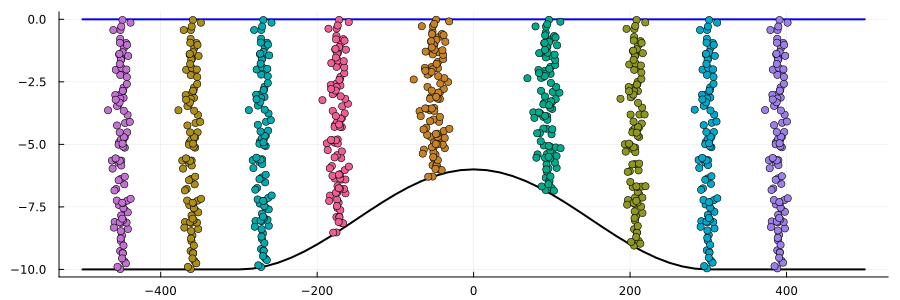

"j:\\Master_Thesis\\particles.jl\\example_notebooks\\bump_example.png"

In [12]:
t_all=d["keep_particle_times"]
fig2 = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig2,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig2,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
d["plot_maps_func"] = plot_maps_xz
# scatter!(fig1,p[1,:],p[2,:],legend=false)
for i in 1:3:length(t_all)
    p_temp=d["all_particles"]
    d["plot_maps_func"](fig2, d, p_temp[i])
end
display(fig2)
